In [10]:
#!c1.8

from functions import *

# fix random state and block_size for divison on blocks
random_state = 12371
block_size = 256

## Forming train and validation sets. Dividing images and masks on blocks

In [11]:
#!c1.8
images_src, images_dest = '/home/jupyter/mnt/datasets/DataLabeled/images/', '/home/jupyter/work/resources/blocks/images/'
labels_src, labels_dest = '/home/jupyter/mnt/datasets/DataLabeled/labels/', '/home/jupyter/work/resources/blocks/labels/'
train_data_json, val_data_json = '/home/jupyter/work/resources/blocks/train_data.json', '/home/jupyter/work/resources/blocks/val_data.json'

In [ ]:
#!c1.8
all_indexes = np.arange(len(list(os.walk(images_src))[0][2]))
val_indexes = np.arange(2, 17)
split = [np.delete(all_indexes, val_indexes), val_indexes]

In [ ]:
#!c1.8

imgs_train, imgs_val = train_val_blocks(images_src, images_dest, ext='.tif', block_size=block_size, split=split)
masks_train, masks_val = train_val_blocks(labels_src, labels_dest, ext='.npy', block_size=block_size, split=split,
                                                      put_dict_sum=True, json_name = 'mask_sums')

with open(train_data_json, 'w') as f:
    json.dump(dict(zip(imgs_train, masks_train)), f)

with open(val_data_json, 'w') as f:
    json.dump(dict(zip(imgs_val, masks_val)), f)

## Getting thresholded blocks

In [12]:
#!c1.8
with open(train_data_json, 'r') as f:
    train_data = json.load(f)

with open('/home/jupyter/work/resources/blocks/labels/mask_sums_train.json', 'r') as f:
    train_sums = json.load(f)
    
with open(val_data_json, 'r') as f:
    val_data = json.load(f)
    
with open('/home/jupyter/work/resources/blocks/labels/mask_sums_val.json', 'r') as f:
    val_sums = json.load(f)


pairs_train = np.array(list(train_data.items()))
values_train = np.array(list(train_sums.values()))

pairs_val = np.array(list(val_data.items()))
values_val = np.array(list(val_sums.values()))

In [13]:
#!c1.8
threshold = 150
indexes_selected_train = np.argwhere(values_train > threshold).squeeze()
indexes_selected_val = np.argwhere(values_val > threshold).squeeze()

indexes_train_zero = np.argwhere(values_train == 0).squeeze()
indexes_train_other = np.random.choice(indexes_train_zero, size=indexes_selected_train.shape[0], replace=False)

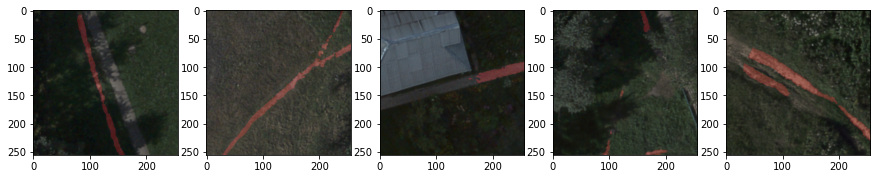

In [14]:
#!c1.8

# visualizing train blocks blended with masks
blocks_num = np.random.choice(indexes_selected_train, 5, replace=False)
blocks_blended = []
for img_name, mask_name in pairs_train[blocks_num]:
    image = io.imread(img_name, plugin='tifffile')
    mask = np.load(mask_name)
    blocks_blended.append(blend(image, mask))

show_images(blocks_blended)

## Getting augmentations

In [15]:
#!c1.8
import albumentations as A
import random

In [16]:
#!c1.8
transforms_comp = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Perspective(),
    A.CropNonEmptyMaskIfExists(height=220, width=220),
    A.Resize(height=block_size, width=block_size, interpolation=2)
])

In [17]:
#!c1.8
random.seed(random_state)
num_augs_train = 40
num_augs_val = 15

dest_augs_dir = '/home/jupyter/work/resources/blocks_augs'
augs_train_json, augs_val_json = os.path.join(dest_augs_dir, 'train_augs.json'), os.path.join(dest_augs_dir, 'val_augs.json')

put_augs(pairs_train[indexes_selected_train], dest_augs_dir, transforms=transforms_comp, num_augs=num_augs_train, json_path=augs_train_json)
put_augs(pairs_val[indexes_selected_val], dest_augs_dir, transforms=transforms_comp, num_augs=num_augs_val, json_path=augs_val_json)

In [18]:
#!c1.8
with open(augs_train_json, 'r') as f:
    augs_train = json.load(f)

with open(augs_val_json, 'r') as f:
    augs_val = json.load(f)

pairs_train_augs = np.array(list(augs_train.items()))
pairs_val_augs = np.array(list(augs_val.items()))

In [19]:
#!c1.8
print(f'Len of train set: {pairs_train_augs.shape[0] + len(indexes_selected_train) + len(indexes_train_other)}')
print(f'Len of validation set: {pairs_val_augs.shape[0] + len(indexes_selected_val)}')

Len of train set: 29536
Len of validation set: 2072


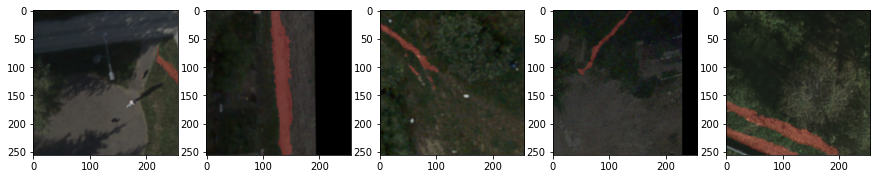

In [22]:
#!c1.8

# visualizing train augmented blocks blended with masks
blocks_num = np.random.choice(np.arange(pairs_train_augs.shape[0]), 5, replace=False)
blocks_blended = []
for img_name, mask_name in pairs_train_augs[blocks_num]:
    image = io.imread(img_name)
    mask = np.load(mask_name)
    blocks_blended.append(blend(image, mask))

show_images(blocks_blended)

In [23]:
#!c1.8

train_json, val_json = '/home/jupyter/work/resources/train.json', '/home/jupyter/work/resources/val.json'

dict_train = np.concatenate((pairs_train_augs, pairs_train[indexes_selected_train], pairs_train[indexes_train_other]))
dict_val = np.concatenate((pairs_val_augs, pairs_val[indexes_selected_val]))

with open(train_json, 'w') as f:
    json.dump(dict(dict_train), f)

with open(val_json, 'w') as f:
    json.dump(dict(dict_val), f)

## Training Neural Network

In [9]:
#!g1.1

# dependencies
# %pip install segmentation-models-pytorch
# %pip install pytorch_toolbelt

from walking_paths import *

config_path, save_state_path = './main_config.yaml', './pipeline_attnet4.pth'
with open(config_path) as f:
    hparams = yaml.load(f, Loader=yaml.SafeLoader)

# if hparams["model"]["encoder_weights"] == 'None': hparams["model"]["encoder_weights"] = None

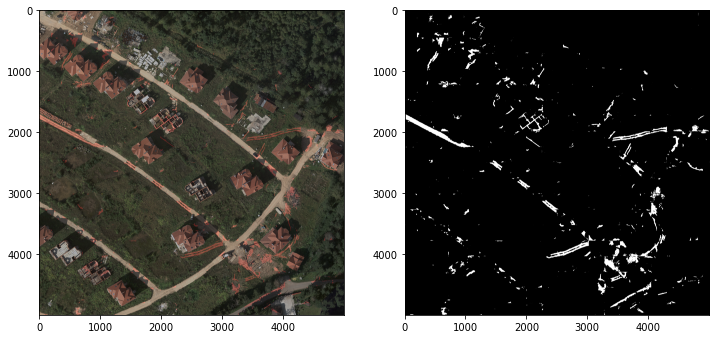

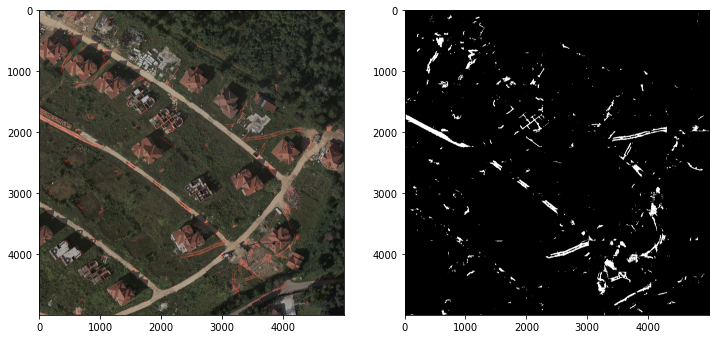

Len train samples =  29536
Len val samples =  2072
Val dataloader =  259
[Epoch   0] val_loss: 0.1776, val_f1: 0.7190, val_precision: 0.6071, val_recall: 0.8852Train dataloader =  923
[Epoch   0] val_loss: 0.2569, val_f1: 0.5886, val_precision: 0.4796, val_recall: 0.8893[Epoch   0] train_loss: 0.1559, f1: 0.6520, precision: 0.5034, recall: 0.9411

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | AttU_Net | 34.9 M
-----------------------------------
34.9 M    Trainable params
0         Non-trainable params
34.9 M    Total params
139.514   Total estimated model params size (MB)
/home/jupyter/.local/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/jupyter/work/resources/checkpoints_AttU_Net exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Epoch 0, global step 922: val_f1 reached 0.58864 (best 0.58864), saving model to "/home/jupyter/work/resources/checkpoints_AttU_Net/epoch=0-val_f1=0.58864.ckpt" as top 1
/home/jupyter/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterru

In [2]:
#!g1.1
# from torchsummary import summary

# TRAINING NEURAL NETWORK HERE

# continue training from checkpoint
pipeline = WalkingPathsDetector.load_from_checkpoint(checkpoint_path="./epoch=0-val_f1=0.59835.ckpt", hparams=hparams).to('cuda')
# pipeline = WalkingPathsDetector(hparams).to(torch.device('cuda'))

# summary(pipeline, (3, 256, 256))

trainer = object_from_dict(
    hparams["trainer"],
    callbacks=[object_from_dict(hparams["checkpoint"])],
    logger=object_from_dict(hparams["logger"])
)

trainer.fit(pipeline)
torch.save(pipeline.state_dict(), save_state_path)

## Looking at the results 

In [ ]:
#!g1.1
test_dir = hparams["test_dir"]
filenames = sorted(list(os.walk(test_dir))[0][2])
test_paths = [os.path.join(test_dir, filename) for filename in filenames]

In [ ]:
#!g1.1
test_img_path = test_paths[30]
test_image = io.imread(test_img_path, plugin='tifffile')
show_images([test_image])
print(test_img_path)

In [26]:
#!g1.1

model = WalkingPathsDetector.load_from_checkpoint(checkpoint_path='./epoch=0-val_f1=0.59835.ckpt', hparams=hparams).to('cuda')
model.eval()

test_predict = model.predict(test_image, block_size=256)

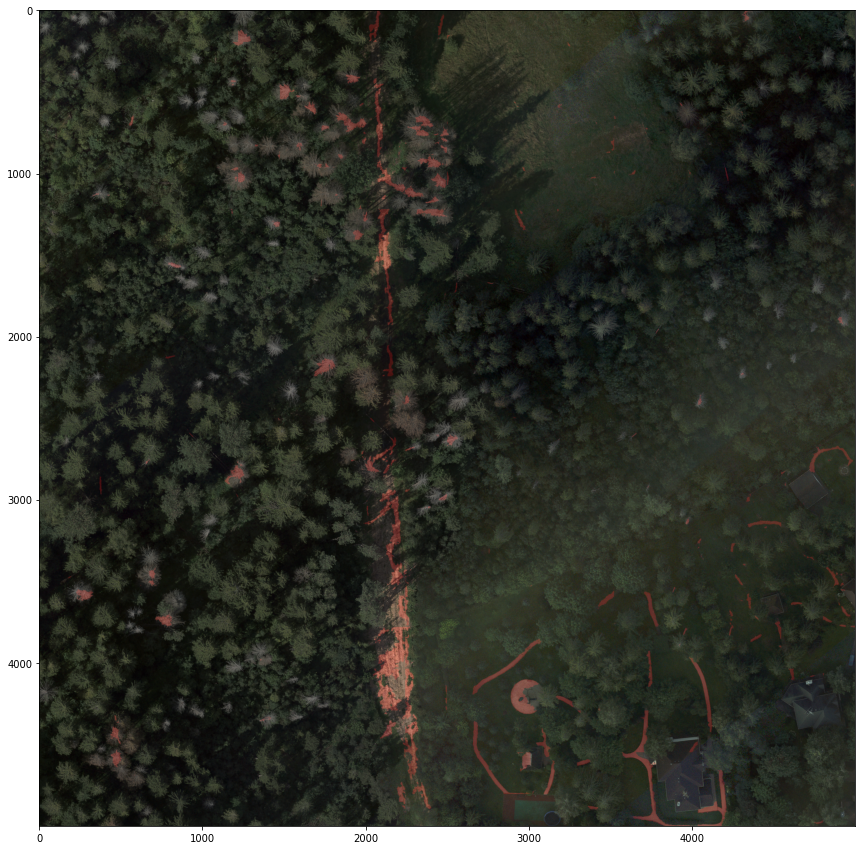

In [27]:
#!g1.1
test_blend = blend(test_image, test_predict)
show_images([test_blend])